In [81]:
!pip install pandas
!pip install torch
!pip install torchvision
!pip install qiskit
!pip install sklearn

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap

In [83]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])
    
simulator = qiskit.Aer.get_backend('qasm_simulator')
circuit = QuantumCircuit(3, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 61.7


┌───┐ ░ ┌───────────┐ ░ ┌─┐      
   q_0: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├──────
        ├───┤ ░ ├───────────┤ ░ └╥┘┌─┐   
   q_1: ┤ H ├─░─┤ Ry(theta) ├─░──╫─┤M├───
        ├───┤ ░ ├───────────┤ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├─░─┤ Ry(theta) ├─░──╫──╫─┤M├
        └───┘ ░ └───────────┘ ░  ║  ║ └╥┘
meas: 3/═════════════════════════╩══╩══╩═
                                 0  1  2

In [84]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(2, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [85]:
children = pd.read_csv('encoded.csv')
children = children.drop(axis=1, columns=['Unnamed: 0'])
print(children.shape)
children.head()

(292, 14)


,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,gender,jundice,Class/ASD,autism
0,1,1,0,0,1,1,0,1,0,0,0,0,0,0
1,1,1,0,0,1,1,0,1,0,0,0,0,0,0
2,1,1,0,0,0,1,1,1,0,0,0,0,0,0
3,0,1,0,0,1,1,0,0,0,1,1,1,0,0
4,1,1,1,1,1,1,1,1,1,1,0,1,1,0


In [86]:
adult = pd.read_csv('EncodedAdolescent.csv')
adult = adult.drop(axis=1, columns=['id'])
adult.rename(columns={"austim": "autism"}, inplace=True)
adult.head()

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,gender,jundice,Class/ASD,autism
0,0,0,0,1,1,1,1,1,1,0,0,1,0,1
1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,1,0,0,0
3,0,1,1,1,1,1,0,1,1,0,1,0,1,0
4,1,1,1,1,1,1,1,0,0,0,1,0,1,0


In [87]:
data = pd.concat([children, adult])
data.reset_index(inplace=True)
data = data.drop(axis=1, columns=['index'])
print(data.shape)
data.tail()

(396, 14)


,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,gender,jundice,Class/ASD,autism
391,0,1,1,1,0,1,1,0,1,0,1,0,0,0
392,1,0,1,0,0,0,0,1,0,1,0,0,0,0
393,1,0,0,1,1,1,1,1,1,1,1,0,1,0
394,1,1,0,1,1,0,0,0,1,1,1,0,0,0
395,1,0,1,0,0,1,1,1,1,0,0,0,0,0


In [88]:
def partition(data, n):
    """Randomly partitions the data into n non-overlapping parts
    Args:
        data: dataframe object, the dataset to partition
        n: number of equal parts to split the data
    Returns:
        splits: list of n parts of the data, each one is a dataframe
    """
    splits = []
    remaining = data.copy(deep=True)
    for i in range(n):
        split = remaining.sample(frac=1/(n-i), random_state=10)
        splits.append(split)
        remaining = remaining.drop(split.index)
    return splits

# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [89]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None, target_transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [90]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(13, 13)
        self.fc2 = nn.Linear(13, 1)
        self.hybrid1 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        # self.hybrid2 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        # x = F.relu(self.conv1(x))
        # x = F.max_pool2d(x, 2)
        # x = F.relu(self.conv2(x))
        # x = F.max_pool2d(x, 2)
        # x = self.dropout(x)
        # x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        x = self.hybrid1(x)
        # x = self.hybrid2(x)
        return torch.cat((x, 1 - x), -1)

In [91]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()
epochs = 20
model.train()

Net(
  (fc1): Linear(in_features=13, out_features=13, bias=True)
  (fc2): Linear(in_features=13, out_features=1, bias=True)
  (hybrid1): Hybrid()
)

In [92]:
model.hybrid1.quantum_circuit._circuit.draw()

┌───┐ ░ ┌───────────┐ ░ ┌─┐   
   q_0: ┤ H ├─░─┤ Ry(theta) ├─░─┤M├───
        ├───┤ ░ ├───────────┤ ░ └╥┘┌─┐
   q_1: ┤ H ├─░─┤ Ry(theta) ├─░──╫─┤M├
        └───┘ ░ └───────────┘ ░  ║ └╥┘
meas: 2/═════════════════════════╩══╩═
                                 0  1

In [93]:
def train_model(model, optimizer, epochs, train_loader, test_loader):
    train_loss_list = []
    for epoch in range(epochs):
        losses = []
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            # Forward pass
            output = model(data)
            # Calculate loss
            loss = loss_func(output, target)
            # Backward pass
            loss.backward()
            # Optimize weights
            optimizer.step()
            losses.append(loss.item())
        train_loss_list.append(sum(losses)/len(losses))
        print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, train_loss_list[-1]))
        
    model.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        losses = []
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            losses.append(loss.item())

        print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
            sum(losses) / len(losses),
            correct / len(test_loader) * 100)
            )
        test_loss = sum(losses) / len(losses)
        accuracy = correct / len(test_loader) * 100
    return train_loss_list, test_loss, accuracy

In [94]:
from sklearn.model_selection import train_test_split

In [95]:
X = data.drop(axis=1, columns=['autism'])
Y = data.autism.astype('int64')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
training_times = []
all_accuracy = []
all_train_loss = []
all_test_loss = []

X_train_series_list = []
for _, row in X_train.iterrows():
    tensor_from_series = df_to_tensor(row)
    X_train_series_list.append(tensor_from_series)
X_train_tensor = torch.stack(X_train_series_list)

Y_train_tensor = df_to_tensor(Y_train)
Y_train_tensor = Y_train_tensor.type(torch.int64)

train_data = CustomDataset(data=X_train_tensor, targets=Y_train_tensor)

X_test_series_list = []
for _, row in X_test.iterrows():
    tensor_from_series = df_to_tensor(row)
    X_test_series_list.append(tensor_from_series)
X_test_tensor = torch.stack(X_test_series_list)

Y_test_tensor = df_to_tensor(Y_test)
Y_test_tensor = Y_test_tensor.type(torch.int64)

test_data = CustomDataset(data=X_test_tensor, targets=Y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

print(f"Train: {len(X_train)} samples, test: {len(X_test)} samples")
t = time()
train_loss_list, test_loss, accuracy = train_model(model, optimizer, epochs, train_loader, test_loader)
training_times.append(time() - t)
print("Training time: %.2fs" % (time() - t))
all_accuracy.append(accuracy)
all_train_loss.append(train_loss_list)
all_test_loss.append(test_loss)

Train: 277 samples, test: 119 samples


/tmp/ipykernel_844/3728979229.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -5.2744
Training [10%]	Loss: -6.9918
Training [15%]	Loss: -7.1042
Training [20%]	Loss: -7.1663
Training [25%]	Loss: -7.1952
Training [30%]	Loss: -7.2537
Training [35%]	Loss: -7.2777
Training [40%]	Loss: -7.2868
Training [45%]	Loss: -7.3031
Training [50%]	Loss: -7.3188
Training [55%]	Loss: -7.3294
Training [60%]	Loss: -7.3299
Training [65%]	Loss: -7.3334
Training [70%]	Loss: -7.3416
Training [75%]	Loss: -7.3416
Training [80%]	Loss: -7.3429
Training [85%]	Loss: -7.3460
Training [90%]	Loss: -7.3501
Training [95%]	Loss: -7.3452


In [47]:
torch.save(model.state_dict(), 'model')

In [48]:
# Avg accuracy
# Old: 83.78954423449514
# Old: 82.68787456241874
# New: 84.82051282051282
# 87.39495798319328
sum(all_accuracy) / len(all_accuracy)

87.39495798319328

In [49]:
# Avg test loss
sum(all_test_loss) / len(all_test_loss)

-81.55722689075624

In [50]:
# Avg training time
sum(training_times) / len(training_times)

140.1014757156372

Text(0, 0.5, '%')

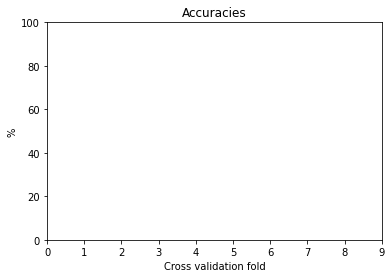

In [51]:
ax = plt.gca()
ax.set_xlim([0, 9])
ax.set_ylim([0, 100])

plt.plot(all_accuracy)
plt.title('Accuracies')
plt.xlabel('Cross validation fold')
plt.ylabel('%')